In [ ]:
import numpy as np
import jax
import jax.numpy as jnp

from deep_parity.jax.boolean_cube import fourier_transform, generate_all_binary_arrays

from pathlib import Path

import polars as pl
from plotnine import ggplot, qplot, aes, geom_point, geom_histogram, facet_wrap, labs

from google.cloud import storage
import equinox as eqx

import treescope 

treescope.basic_interactive_setup(autovisualize_arrays=True)


def try_load_checkpoint(model_template, bucket_name, config, step):
    """Try to load the latest checkpoint from GCS bucket"""
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    
    # Find checkpoints
    n = config['model']['n']
    seed = config['seed']
    model_dim = config['model']['model_dim']
    checkpoint_dir = f"full/one-layer/model_dim={model_dim}/n={n}/seed={seed}"
    blobs = list(bucket.list_blobs(prefix=f"{checkpoint_dir}/model_"))
    
    if not blobs:
        print("No checkpoints found, starting fresh training")
        return None
    
    # Download latest checkpoint files
    model_blob = bucket.blob(f"{checkpoint_dir}/model_{step}.eqx")
    model_local_path = f"/tmp/model_{step}.eqx"
    model_blob.download_to_filename(model_local_path)

  
    model = eqx.tree_deserialise_leaves(model_local_path, model_template)
    
    return model


def try_load_fim(bucket_name, config, step):
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    
    n = config['model']['n']
    seed = config['seed']
    model_dim = config['model']['model_dim']
    checkpoint_dir = Path(f"fisher_information_matrix/one-layer/model_dim={model_dim}/n={n}/seed={seed}")
        
    # Download latest checkpoint files
    tensor_blob = bucket.blob(str(f"{checkpoint_dir}/{step}/fim{step}.npy"))
    tensor_blob_path = f"/tmp/{step}.npy"
    tensor_blob.download_to_filename(tensor_blob_path)
    
    return np.load(tensor_blob_path)





In [2]:
import equinox as eqx
import jax
import jax.numpy as jnp
from jax.nn import relu
from functools import partial


class Perceptron(eqx.Module):
    linear: eqx.Module
    unembed: eqx.Module

    def __init__(self, n: int, model_dim: int, key):
        linear_key, unembed_key = jax.random.split(key)
        self.linear = eqx.nn.Linear(in_features=n, out_features=model_dim, key=linear_key, dtype=jnp.float32)
        self.unembed = eqx.nn.Linear(in_features=model_dim, out_features=2, use_bias=False, key=unembed_key, dtype=jnp.float32)
    
    def __call__(self, x):
        preactivations = self.linear(x)
        outputs = self.unembed(relu(preactivations))
        return outputs


In [3]:
import optax
from jax.sharding import PartitionSpec as P, NamedSharding
import scipy


def generate_boolean_cube(n: int):
    return np.sign(-1. * (generate_all_binary_arrays(n) - 0.5).astype(float))


def compute_loss(model, batch_x, batch_y):
    pred = model(batch_x)
    
    target_one_hot = jax.nn.one_hot(
        (batch_y == 1.).astype(int),
        num_classes=2
    )
    
    loss = optax.softmax_cross_entropy(
        pred,
        target_one_hot
    )
    
    # Compute entropy of predictions
    return loss



In [4]:
n = 20
model_dim = 256
step = 30_000
seed = 0

config = {'model': {'n': n, 'model_dim': model_dim}, 'seed': seed}

model_bucket = "deep-parity-training-0"
hessian_bucket = "deep-parity-hessian"

key = jax.random.key(0)

template = Perceptron(n, model_dim, key)

model = try_load_checkpoint(template, model_bucket, config, step)
FIM_final = try_load_fim(hessian_bucket, config, step)


NotFound: 404 GET https://storage.googleapis.com/download/storage/v1/b/deep-parity-hessian/o/fisher_information_matrix%2Fone-layer%2Fmodel_dim%3D256%2Fn%3D20%2Fseed%3D0%2F30000%2Ffim30000.npy?alt=media: No such object: deep-parity-hessian/fisher_information_matrix/one-layer/model_dim=256/n=20/seed=0/30000/fim30000.npy: ('Request failed with status code', 404, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)

In [7]:
FIM_final

array([[ 6.89481113e-02, -3.09097528e-03,  1.29528384e-03, ...,
         1.95844661e-03,  2.48829047e-02, -6.39126954e-02],
       [-3.09097528e-03,  6.89481113e-02, -1.31023146e-03, ...,
         1.14034927e-02, -2.51409267e-02, -3.28489275e-02],
       [ 1.29528384e-03, -1.31023146e-03,  6.89481113e-02, ...,
         1.17465673e-02,  3.47509512e-02, -3.31160641e-02],
       ...,
       [ 1.95862121e-03,  1.14028599e-02,  1.17456127e-02, ...,
         1.36656077e-01,  8.42346581e-02,  1.92031011e-01],
       [ 2.48768294e-02, -2.51359913e-02,  3.47480119e-02, ...,
         8.42304050e-02,  1.11910828e+00,  2.84621783e-01],
       [-6.39093436e-02, -3.28488240e-02, -3.31153978e-02, ...,
         1.92030823e-01,  2.84639673e-01,  1.95311202e+00]],
      shape=(2944, 2944))

In [8]:

fim_vals, fim_vecs = scipy.linalg.eigh(FIM_final)

In [9]:
(fim_vals <= 1.e-7).sum()

np.int64(134)

/home/dstander/deep-parity/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


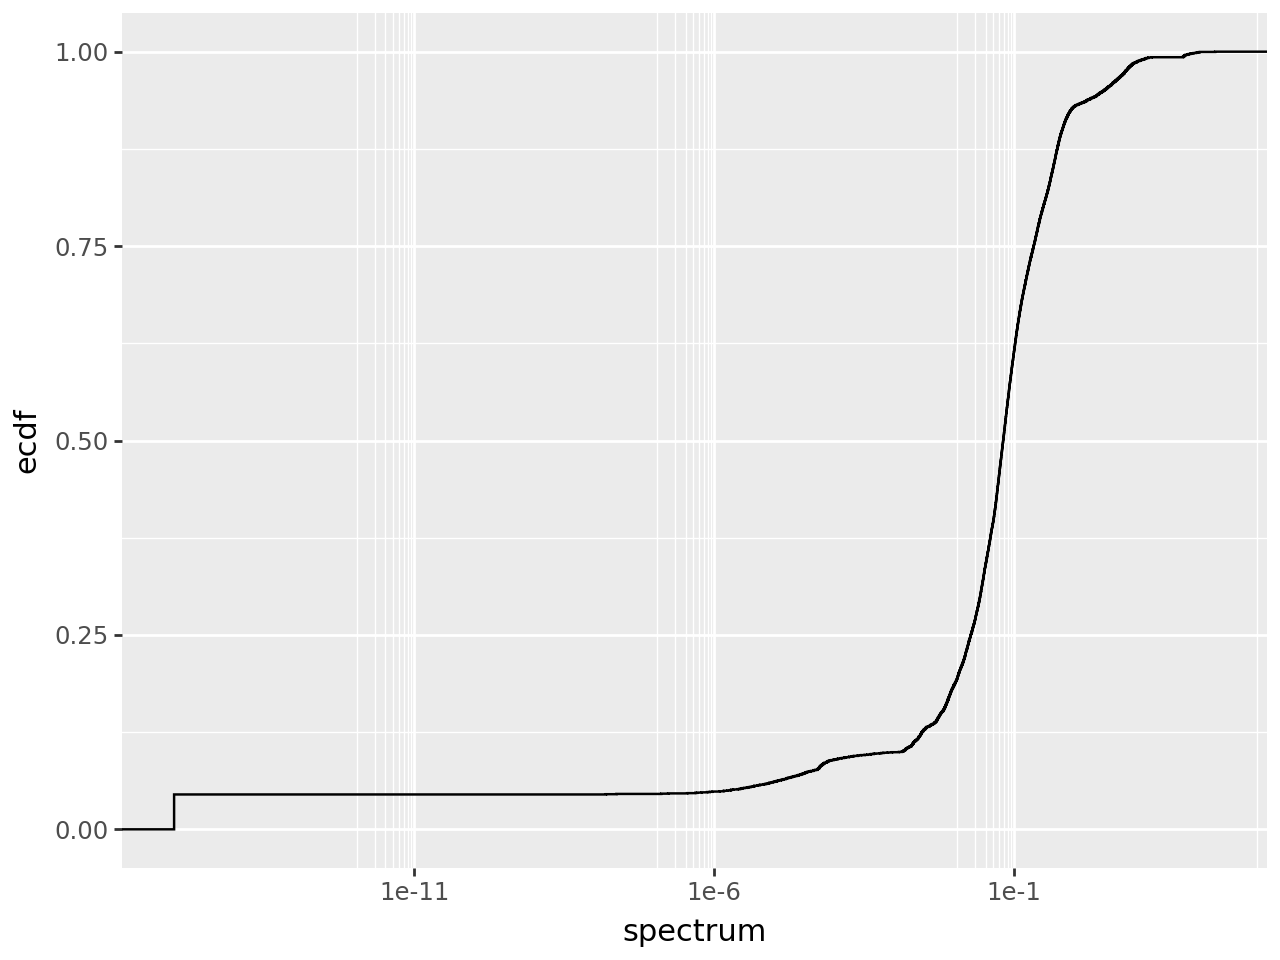

In [10]:
from plotnine import stat_ecdf, scale_x_log10

df = pl.DataFrame({'spectrum': np.clip(fim_vals, min=1.0e-15)})

ggplot(df, aes(x='spectrum')) + stat_ecdf() + scale_x_log10()

In [11]:
weights, unravel_fn = jax.flatten_util.ravel_pytree(model)

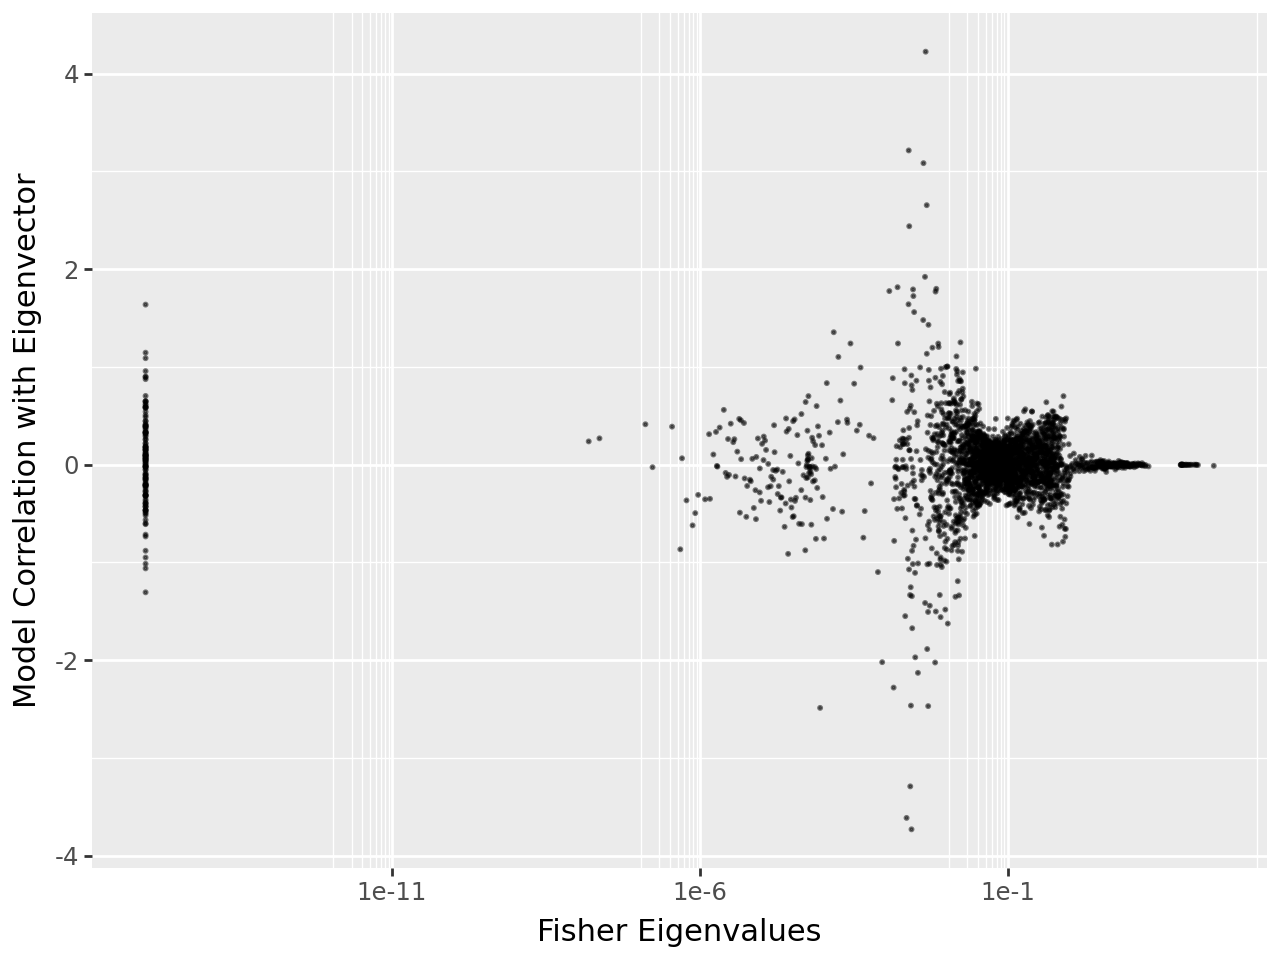

In [12]:
from plotnine import geom_line, labs

correlations = np.array(jnp.array(fim_vecs).T @ weights)
df = pl.DataFrame({'model_projections': correlations, 'eigenvalues': np.clip(fim_vals, min=1.0e-15)}).with_row_index()

(
    ggplot(df, aes(x='eigenvalues', y='model_projections')) + geom_point(size=0.2, alpha=0.5) + scale_x_log10()
    + labs(x = 'Fisher Eigenvalues', y='Model Correlation with Eigenvector')
)

In [23]:
lr = 0.01

proj_weights = weights - lr * (fim_vecs[:, :137] @ (fim_vecs[:, :137].T @ weights))

proj_model = unravel_fn(proj_weights)


In [24]:
jax.vmap(compute_loss, in_axes=(None, 0, 0))(proj_model, cube, parities).mean()

<jax.Array(0.03277144, dtype=float32)>

In [25]:
jax.vmap(compute_loss, in_axes=(None, 0, 0))(model, cube, parities).mean()

<jax.Array(0.03253228, dtype=float32)>

In [16]:

n_devices = jax.device_count()
mesh = jax.make_mesh((n_devices,), ('tensor',))
sharded = jax.sharding.NamedSharding(mesh, P('tensor',))
replicated = jax.sharding.NamedSharding(mesh, P(None,))


cube = jnp.array(generate_boolean_cube(n))
#cube = jax.device_put(cube, sharded)   
parities = cube.prod(axis=-1)
model = jax.device_put(model, replicated)
#proj_model = jax.device_put(proj_model, replicated)


In [39]:
import jax.flatten_util
import scipy.linalg


def model_logits(model, tensor):
    logits = jax.nn.log_softmax(model(tensor))
    return logits


def softmax_jacobian(probs):
    """
    Args:
        p: JAX array of shape (k,) containing class probabilities
        
    Returns:
        A matrix of shape (k, k) with the structure p(i)δ_ij - p(i)p(j)
    """
    return jnp.diag(probs) - jnp.outer(probs, probs) 


@partial(jax.vmap, in_axes=(None, 0))
def softmax_gradient_outer_product(model, tensor):
    n_classes = 2
    
    # Define a function that extracts gradient for a specific class
    def grad_fn(idx):
        vals, grads = jax.value_and_grad(lambda m, x: model_logits(m, x)[idx])(model, tensor)
        flat_grads, _ = jax.flatten_util.ravel_pytree(grads)
        return vals, flat_grads
    
    
    # logits.shape = (n_classes,)
    logits, gradients = jax.vmap(grad_fn)(jnp.arange(n_classes))
    # gradients.shape = (n_classes, n_parameters)
    gradients = gradients.T
    # Q is the softmax Jacobian -- Amari used Q for some reason
    # Q.shape is (n_classes, n_classes)
    Q = softmax_jacobian(jax.nn.softmax(logits))
    return gradients @ Q @ gradients.T


@jax.jit
def fisher_information(model, tensor):
    return softmax_gradient_outer_product(model, tensor).mean(axis=0)


def calculate_fim(model, cube, n):
    n_devices = jax.device_count()
    mesh = jax.make_mesh((n_devices,), ('tensor',))
    sharded = jax.sharding.NamedSharding(mesh, P('tensor',))
    replicated = jax.sharding.NamedSharding(mesh, P(None,))
    n_params = sum(p.size for p in jax.tree_util.tree_leaves(model))

    full_fisher_information = np.zeros((n_params, n_params), dtype=np.float64)

    model = jax.device_put(model, replicated)

    for i in range(0, 2**n, 2**15):
        j = i + 2**15
        fim_batch = fisher_information(
            model,
            jax.device_put(cube[i:j], sharded),
        )
        full_fisher_information += np.array(fim_batch, dtype=np.float64)
    
    return full_fisher_information




def project_model_fisher(model, boolean_cube, n, lr, eps):
    weights, unravel_fn = jax.flatten_util.ravel_pytree(model)

    fisher_matrix = calculate_fim(model, boolean_cube, n)

    eigenvalues, eigenvecs = scipy.linalg.eigh(fisher_matrix)
    n_vals = (eigenvalues <= eps).sum()
    print(f'{n_vals}/{len(eigenvalues)} eigenvalues below threshold')
    weight_projection = jnp.array(eigenvecs[:, :n_vals]) @ (jnp.array(eigenvecs[:, :n_vals]).T @ weights)
    proj_norm = jnp.pow(weight_projection, 2).sum()
    return unravel_fn(weights - (lr * weight_projection)), proj_norm


## Doing stuff code starts here


base_model = model
proj_model = model

base_probs = jax.nn.softmax(jax.vmap(base_model)(cube))

lr = 0.001
eps = 1.0e-7
n = 20

losses = []
original_kl_div = []
norms = []
for i in range(500):
    print(i)
    proj_model, proj_norm = project_model_fisher(proj_model, cube, n, lr, eps)
    norms.append(proj_norm)
    loss = jax.vmap(compute_loss, in_axes=(None, 0, 0))(model, cube, parities).mean()
    losses.append(loss)
    probs = jax.nn.softmax(jax.vmap(proj_model)(cube))
    kl = jax.vmap(jax.scipy.special.kl_div)(base_probs, probs).sum(axis=1).mean()
    original_kl_div.append(kl)
    print(loss.item(), kl.item(), proj_norm.item())


    








0
134/2944 eigenvalues below threshold
0.032532282173633575 9.018828859552741e-05 28.245071411132812
1
137/2944 eigenvalues below threshold
0.032532282173633575 9.259580838261172e-05 26.221729278564453
2
131/2944 eigenvalues below threshold
0.032532282173633575 9.600654448149726e-05 23.686588287353516
3
130/2944 eigenvalues below threshold
0.032532282173633575 0.00010345365444663912 15.865494728088379
4
133/2944 eigenvalues below threshold
0.032532282173633575 0.00011184825416421518 19.889087677001953
5
132/2944 eigenvalues below threshold
0.032532282173633575 0.00010308493801858276 16.22931671142578
6
132/2944 eigenvalues below threshold
0.032532282173633575 0.0001005907979561016 13.083626747131348
7
132/2944 eigenvalues below threshold
0.032532282173633575 9.767362644197419e-05 15.850298881530762
8
134/2944 eigenvalues below threshold
0.032532282173633575 9.914855763781816e-05 18.125043869018555
9
132/2944 eigenvalues below threshold
0.032532282173633575 0.00010310057405149564 17.241

KeyboardInterrupt: 

In [35]:
from tqdm import trange

base_model = model
proj_model = model

base_probs = jax.nn.softmax(jax.vmap(base_model)(cube))

lr = 0.01
eps = 1.0e-7
n = 20

losses = []
original_kl_div = []
norms = []
for i in range(100):
    print(i)
    proj_model, proj_norm = project_model_fisher(proj_model, cube, n, lr, eps)
    norms.append(proj_norm)
    loss = jax.vmap(compute_loss, in_axes=(None, 0, 0))(model, cube, parities).mean()
    losses.append(loss)
    probs = jax.nn.softmax(jax.vmap(proj_model)(cube))
    kl = jax.vmap(jax.scipy.special.kl_div)(base_probs, probs).sum(axis=1).mean()
    original_kl_div.append(kl)
    print(loss)
    print(kl)


    




0
134/2944 eigenvalues below threshold
0.032532282
0.000124215
1
130/2944 eigenvalues below threshold
0.032532282
0.00011344876
2
129/2944 eigenvalues below threshold
0.032532282
0.00011412709
3
131/2944 eigenvalues below threshold
0.032532282
0.0001299601
4
132/2944 eigenvalues below threshold
0.032532282
0.00011639289
5
129/2944 eigenvalues below threshold
0.032532282
0.00010408451
6
127/2944 eigenvalues below threshold
0.032532282
9.63266e-05
7
127/2944 eigenvalues below threshold
0.032532282
0.00013597582
8
124/2944 eigenvalues below threshold
0.032532282
0.000147385
9
128/2944 eigenvalues below threshold
0.032532282
0.00010771274
10
125/2944 eigenvalues below threshold
0.032532282
0.00011692953
11
128/2944 eigenvalues below threshold
0.032532282
0.00011325463
12
128/2944 eigenvalues below threshold
0.032532282
0.000103038445
13
130/2944 eigenvalues below threshold
0.032532282
0.00013379681
14
131/2944 eigenvalues below threshold
0.032532282
0.00013637704
15
126/2944 eigenvalues be

In [36]:
norms

[<jax.Array(28.245071, dtype=float32)>,
 <jax.Array(20.741549, dtype=float32)>,
 <jax.Array(17.86111, dtype=float32)>,
 <jax.Array(22.619175, dtype=float32)>,
 <jax.Array(24.373129, dtype=float32)>,
 <jax.Array(14.250948, dtype=float32)>,
 <jax.Array(13.93081, dtype=float32)>,
 <jax.Array(14.75304, dtype=float32)>,
 <jax.Array(11.768925, dtype=float32)>,
 <jax.Array(9.478239, dtype=float32)>,
 <jax.Array(15.196672, dtype=float32)>,
 <jax.Array(9.76794, dtype=float32)>,
 <jax.Array(11.4334135, dtype=float32)>,
 <jax.Array(11.239651, dtype=float32)>,
 <jax.Array(15.534826, dtype=float32)>,
 <jax.Array(10.337414, dtype=float32)>,
 <jax.Array(7.80016, dtype=float32)>,
 <jax.Array(12.560153, dtype=float32)>,
 <jax.Array(15.438806, dtype=float32)>,
 <jax.Array(9.982661, dtype=float32)>,
 <jax.Array(10.215782, dtype=float32)>,
 <jax.Array(8.721074, dtype=float32)>,
 <jax.Array(7.737654, dtype=float32)>,
 <jax.Array(7.8649, dtype=float32)>,
 <jax.Array(8.367707, dtype=float32)>,
 <jax.Array(10.249279, dtype=float32)>,
 <jax.Array(7.887528, dtype=float32)>,
 <jax.Array(9.001491, dtype=float32)>,
 <jax.Array(9.362806, dtype=float32)>,
 <jax.Array(10.490855, dtype=float32)>,
 <jax.Array(8.310679, dtype=float32)>,
 <jax.Array(10.768103, dtype=float32)>,
 <jax.Array(7.6717896, dtype=float32)>,
 <jax.Array(5.2937613, dtype=float32)>,
 <jax.Array(6.1119833, dtype=float32)>,
 <jax.Array(5.0071473, dtype=float32)>,
 <jax.Array(10.706851, dtype=float32)>,
 <jax.Array(5.8327665, dtype=float32)>,
 <jax.Array(4.7106915, dtype=float32)>,
 <jax.Array(6.4977818, dtype=float32)>,
 <jax.Array(5.085292, dtype=float32)>,
 <jax.Array(5.3088894, dtype=float32)>,
 <jax.Array(6.278592, dtype=float32)>,
 <jax.Array(5.658666, dtype=float32)>,
 <jax.Array(6.09654, dtype=float32)>,
 <jax.Array(4.363868, dtype=float32)>,
 <jax.Array(5.159086, dtype=float32)>,
 <jax.Array(5.272344, dtype=float32)>,
 <jax.Array(4.5836864, dtype=float32)>,
 <jax.Array(5.934055, dtype=float32)>,
 <jax.Array(6.6365395, dtype=float32)>,
 <jax.Array(6.3430643, dtype=float32)>,
 <jax.Array(7.3137946, dtype=float32)>,
 <jax.Array(4.9145503, dtype=float32)>,
 <jax.Array(4.6926074, dtype=float32)>,
 <jax.Array(4.446166, dtype=float32)>,
 <jax.Array(6.1712565, dtype=float32)>,
 <jax.Array(5.164631, dtype=float32)>,
 <jax.Array(5.312843, dtype=float32)>,
 <jax.Array(4.2666664, dtype=float32)>,
 <jax.Array(4.424826, dtype=float32)>,
 <jax.Array(4.8346734, dtype=float32)>,
 <jax.Array(4.372718, dtype=float32)>,
 <jax.Array(4.9610176, dtype=float32)>,
 <jax.Array(4.929805, dtype=float32)>,
 <jax.Array(4.4485207, dtype=float32)>,
 <jax.Array(4.8732996, dtype=float32)>,
 <jax.Array(3.9862165, dtype=float32)>,
 <jax.Array(3.3066738, dtype=float32)>,
 <jax.Array(4.0055237, dtype=float32)>,
 <jax.Array(3.608671, dtype=float32)>,
 <jax.Array(4.5532575, dtype=float32)>,
 <jax.Array(4.2868047, dtype=float32)>,
 <jax.Array(4.360153, dtype=float32)>,
 <jax.Array(4.6193075, dtype=float32)>,
 <jax.Array(4.0648775, dtype=float32)>,
 <jax.Array(4.3944063, dtype=float32)>,
 <jax.Array(4.4648128, dtype=float32)>,
 <jax.Array(3.8265405, dtype=float32)>,
 <jax.Array(4.129659, dtype=float32)>,
 <jax.Array(4.389364, dtype=float32)>,
 <jax.Array(4.0467443, dtype=float32)>,
 <jax.Array(3.6521783, dtype=float32)>,
 <jax.Array(3.3139896, dtype=float32)>,
 <jax.Array(3.9958112, dtype=float32)>,
 <jax.Array(3.6505554, dtype=float32)>,
 <jax.Array(3.5974884, dtype=float32)>,
 <jax.Array(3.6633213, dtype=float32)>,
 <jax.Array(3.2498202, dtype=float32)>,
 <jax.Array(3.2770054, dtype=float32)>,
 <jax.Array(2.6134338, dtype=float32)>,
 <jax.Array(2.1872718, dtype=float32)>,
 <jax.Array(2.6501777, dtype=float32)>,
 <jax.Array(2.3630068, dtype=float32)>,
 <jax.Array(2.0916772, dtype=float32)>,
 <jax.Array(1.9816337, dtype=float32)>,
 <jax.Array(2.0484068, dtype=float32)>,
 <jax.Array(2.5930781, dtype=float32)>,
 <jax.Array(2.184493, dtype=float32)>,
 <jax.Array(2.6870894, dtype=float32)>]

In [37]:
proj_model

Perceptron(
  linear=Linear(
    weight=f32[128,20],
    bias=f32[128],
    in_features=20,
    out_features=128,
    use_bias=True
  ),
  unembed=Linear(
    weight=f32[2,128],
    bias=None,
    in_features=128,
    out_features=2,
    use_bias=False
  )
)

In [96]:
base_probs = jax.nn.softmax(jax.vmap(model)(cube))
proj_probs = jax.nn.softmax(jax.vmap(proj_model)(cube))

print(jax.vmap(jax.scipy.special.kl_div)(base_probs, proj_probs).mean())

0.017431753


/home/dstander/deep-parity/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 21'. Pick better value with 'binwidth'.


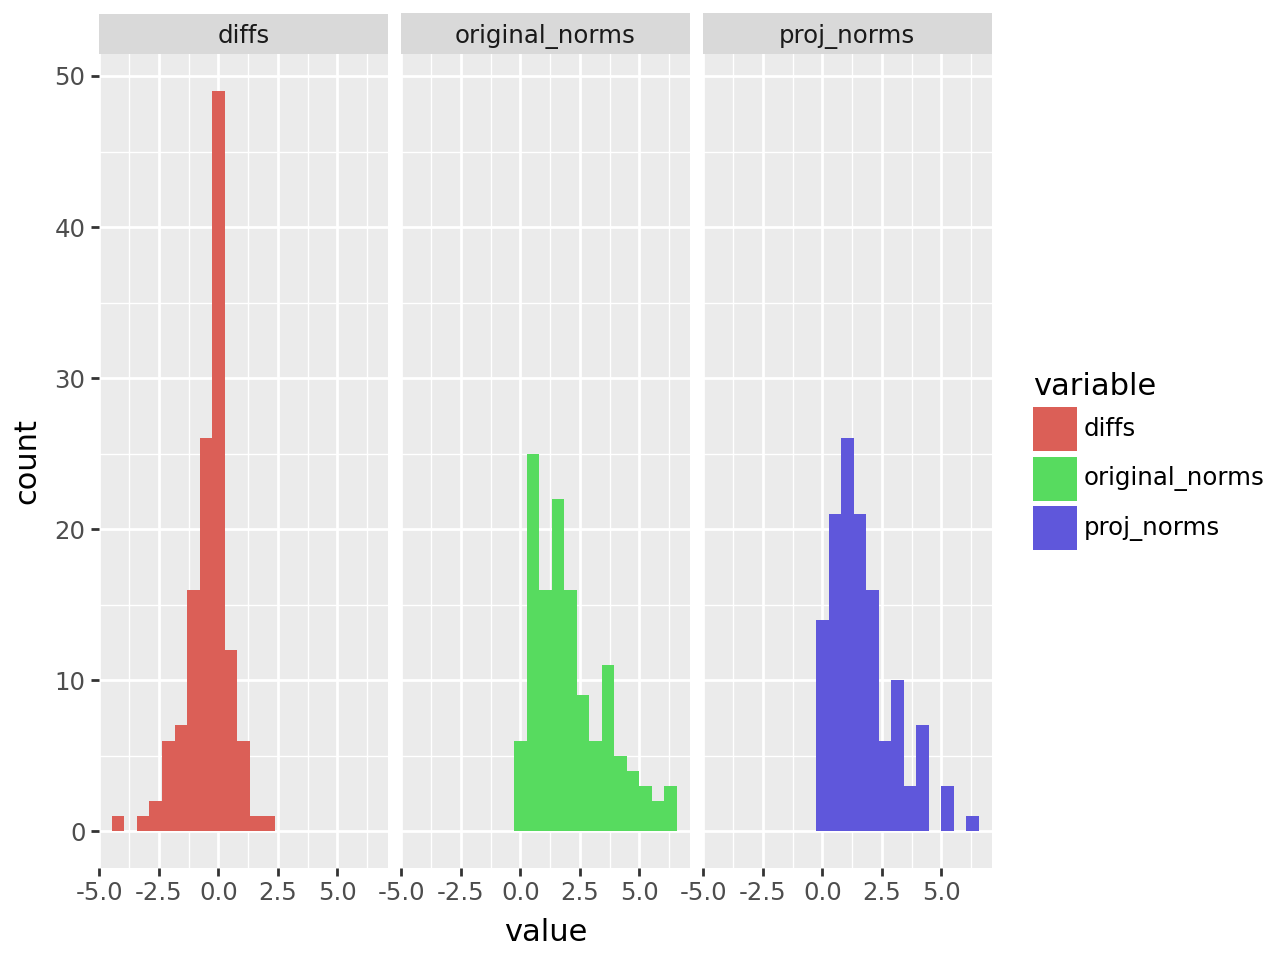

In [100]:
proj_neuron_norms = np.array(jnp.pow(proj_model.linear.weight, 2).sum(axis=1))
original_neuron_norms = np.array(jnp.pow(model.linear.weight, 2).sum(axis=1))

df = pl.DataFrame({'proj_norms': proj_neuron_norms, 'original_norms': original_neuron_norms, 'diffs': (proj_neuron_norms - original_neuron_norms)}).with_row_index()
df = df.unpivot(index='index')

ggplot(df, aes(x='value', fill='variable')) + geom_histogram() + facet_wrap('~variable')

In [106]:
batch_fim = fisher_information(model, jax.device_put(cube[:2**15], sharded))

In [107]:
batch_fim

<jax.Array float32(5888, 5888) ≈1.7e-07 ±0.00064 [≥-0.016, ≤0.016] zero:48_668 nonzero:34_619_876
  <Arrayviz rendering>
  Replicated across 8 TPU devices (click to expand)
>

In [108]:
total_fisher_info = np.zeros((5888, 5888), dtype=np.float64)

for i in range(0, 2**n, 2**15):
    j = i + 2**15
    batch_fim = fisher_information(model, cube[i:j])
    total_fisher_info += np.array(batch_fim, dtype=np.float64)
    
total_fisher_info /= len(range(0, 2**n, 2**15))

In [109]:
import scipy

#vals, vecs = jnp.linalg.eigh(jnp.array(total_fisher_info))

vals, vecs = scipy.linalg.eigh(total_fisher_info)

In [110]:
weights, unravel_fn = jax.flatten_util.ravel_pytree(model)

/home/dstander/deep-parity/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


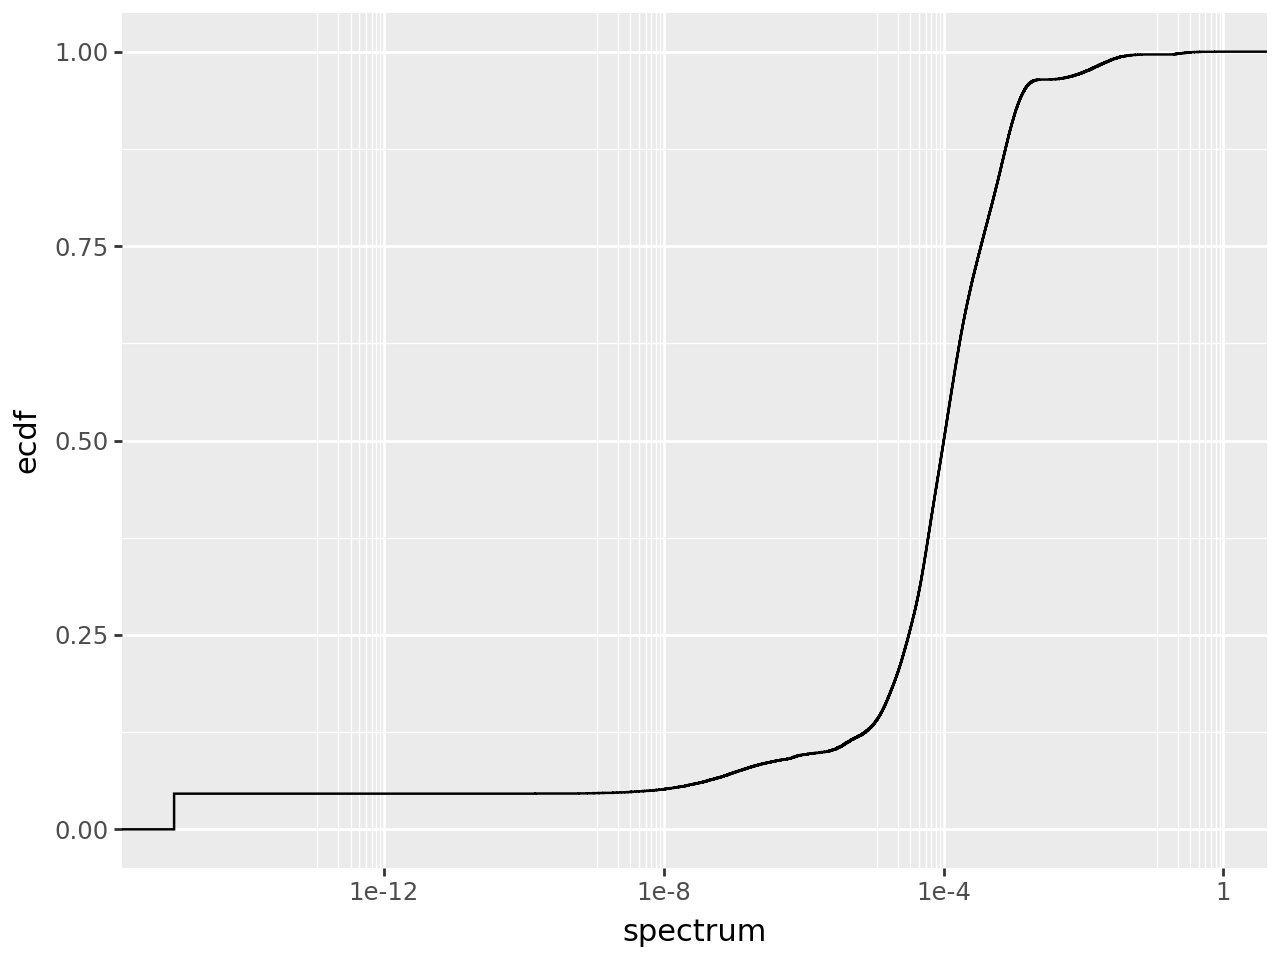

In [112]:
df = pl.DataFrame({'spectrum': np.clip(vals, min=1.0e-15)})

ggplot(df, aes(x='spectrum')) + stat_ecdf() + scale_x_log10()

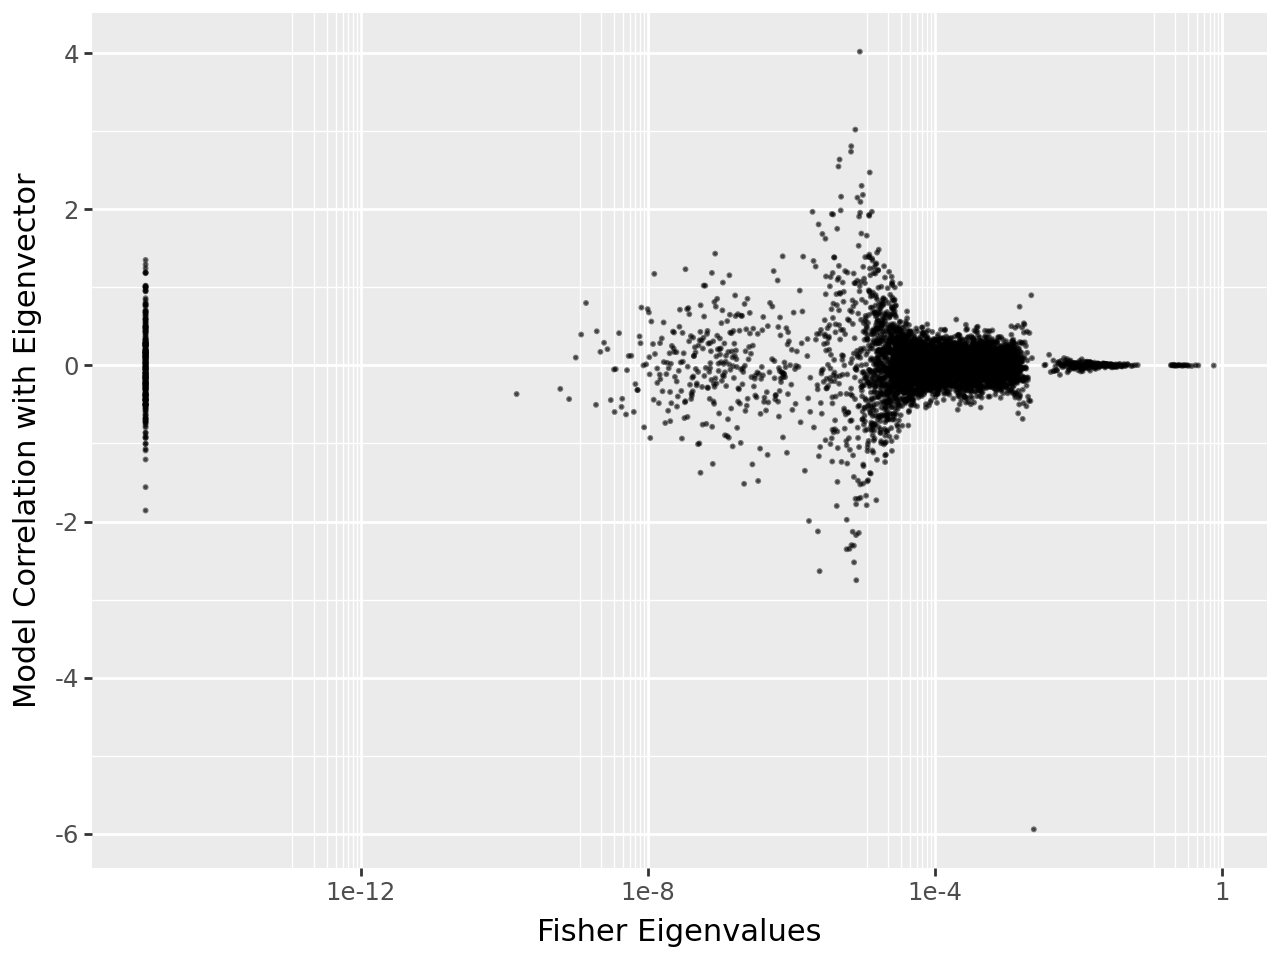

In [113]:
correlations = np.array(jnp.array(vecs).T @ weights)
df = pl.DataFrame({'model_projections': correlations, 'eigenvalues': np.clip(vals, min=1.0e-15)}).with_row_index()

(
    ggplot(df, aes(x='eigenvalues', y='model_projections')) + geom_point(size=0.2, alpha=0.5) + scale_x_log10()
    + labs(x = 'Fisher Eigenvalues', y='Model Correlation with Eigenvector')
)

In [114]:
(vals < 1.e-12).sum()

np.int64(270)

In [117]:
weights, unravel_fn = jax.flatten_util.ravel_pytree(model)

proj_weights = vecs[:, 270:] @ (vecs[:, 270:].T @ weights)

proj_model = unravel_fn(proj_weights)
unravel_fn(weights - proj_weights)

Perceptron(
  linear=Linear(
    weight=f32[256,20],
    bias=f32[256],
    in_features=20,
    out_features=256,
    use_bias=True
  ),
  unembed=Linear(
    weight=f32[2,256],
    bias=None,
    in_features=256,
    out_features=2,
    use_bias=False
  )
)

In [124]:
proj_model

Perceptron(
  linear=Linear(
    weight=f32[256,20],
    bias=f32[256],
    in_features=20,
    out_features=256,
    use_bias=True
  ),
  unembed=Linear(
    weight=f32[2,256],
    bias=None,
    in_features=256,
    out_features=2,
    use_bias=False
  )
)

In [130]:

import random

idx = random.randint(0, 128)
w = proj_model.linear.weight[idx]
min_val = jnp.abs(w).min()
sorted_inds = jnp.argsort(jnp.abs(w))

w[sorted_inds] / min_val


<jax.Array float32(20,) ≈-0.1 ±1.0 [≥-1.0, ≤1.0] nonzero:20
  <Arrayviz rendering>
  Replicated across 8 TPU devices (click to expand)
>

In [118]:
jax.vmap(compute_loss, in_axes=(None, 0, 0))(proj_model, cube, parities).mean()

<jax.Array(0.03235661, dtype=float32)>

In [119]:
jax.vmap(compute_loss, in_axes=(None, 0, 0))(model, cube, parities).mean()

<jax.Array(0.00169939, dtype=float32)>

In [122]:
base_probs = jax.nn.softmax(jax.vmap(model)(cube))
proj_probs = jax.nn.softmax(jax.vmap(proj_model)(cube))

jax.vmap(jax.scipy.special.kl_div)(base_probs, proj_probs)

<jax.Array float32(1048576, 2) ≈0.014 ±0.078 [≥-6.6e-06, ≤4.7] zero:376_995 nonzero:1_720_157
  <Arrayviz rendering>
  Replicated across 8 TPU devices (click to expand)
>

In [54]:
jnp.abs(projected_params - weights)

<jax.Array float32(2944,) ≈0.013 ±0.014 [≥3.9e-06, ≤0.14] nonzero:2_944
  <Arrayviz rendering>
  Replicated across 8 TPU devices (click to expand)
>

In [61]:
unravel_fn(vecs[:, -20])

Perceptron(
  linear=Linear(
    weight=f32[128,20],
    bias=f32[128],
    in_features=20,
    out_features=128,
    use_bias=True
  ),
  unembed=Linear(
    weight=f32[2,128],
    bias=None,
    in_features=128,
    out_features=2,
    use_bias=False
  )
)

In [26]:
eigen_model = unravel_fn(h_vecs[:, idx])
print(h_values[idx])
print((jnp.abs(eigen_model.linear.weight) > 1.0e-2).sum())
eigen_model

3.4378394e-05
712


Perceptron(
  linear=Linear(
    weight=f32[128,20],
    bias=f32[128],
    in_features=20,
    out_features=128,
    use_bias=True
  ),
  unembed=Linear(
    weight=f32[2,128],
    bias=None,
    in_features=128,
    out_features=2,
    use_bias=False
  )
)

In [6]:
all_steps = list(range(0, 2000, 20)) + list(range(2000, 30_001, 1000))

_data = []

for step in all_steps:
    H = try_load_hessian(hessian_bucket, config, step)
    vals = jnp.linalg.eigvalsh(H)
    df = pl.DataFrame({'spectrum': np.array(vals)}).with_row_index().with_columns(step=pl.lit(step))
    _data.append(df)


spectral_data = pl.concat(_data)
    

In [ ]:
def eigen_data(model, eigenvector, eigenvalue, unravel_function, idx):
    eigen_model = unravel_function(eigenvector)
    main_l2 = jnp.pow(model.linear.weight, 2).sum(axis=1)


    weight_l2 = jnp.pow(eigen_model.linear.weight, 2).sum(axis=1)
    weight_l1 = jnp.abs(eigen_model.linear.weight).sum(axis=1)
    weight_l0 = jnp.abs(eigen_model.linear.weight).max(axis=1)
    weight_std = jnp.abs(eigen_model.linear.weight).std(axis=1)
    weight_alignment = jax.vmap(jnp.dot)(eigen_model.linear.weight, model.linear.weight)
    

    data = pl.DataFrame({
        'l2': np.array(weight_l2),
        'l1': np.array(weight_l1),
        'l0': np.array(weight_l0),
        'weight_stddev': np.array(weight_std),
        'weight_alignment': np.array(weight_alignment)
    }).with_columns(eigenvalue=pl.lit(eigenvalue), eigen_index=pl.lit(idx)).with_row_index()
    return data

/home/dstander/deep-parity/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


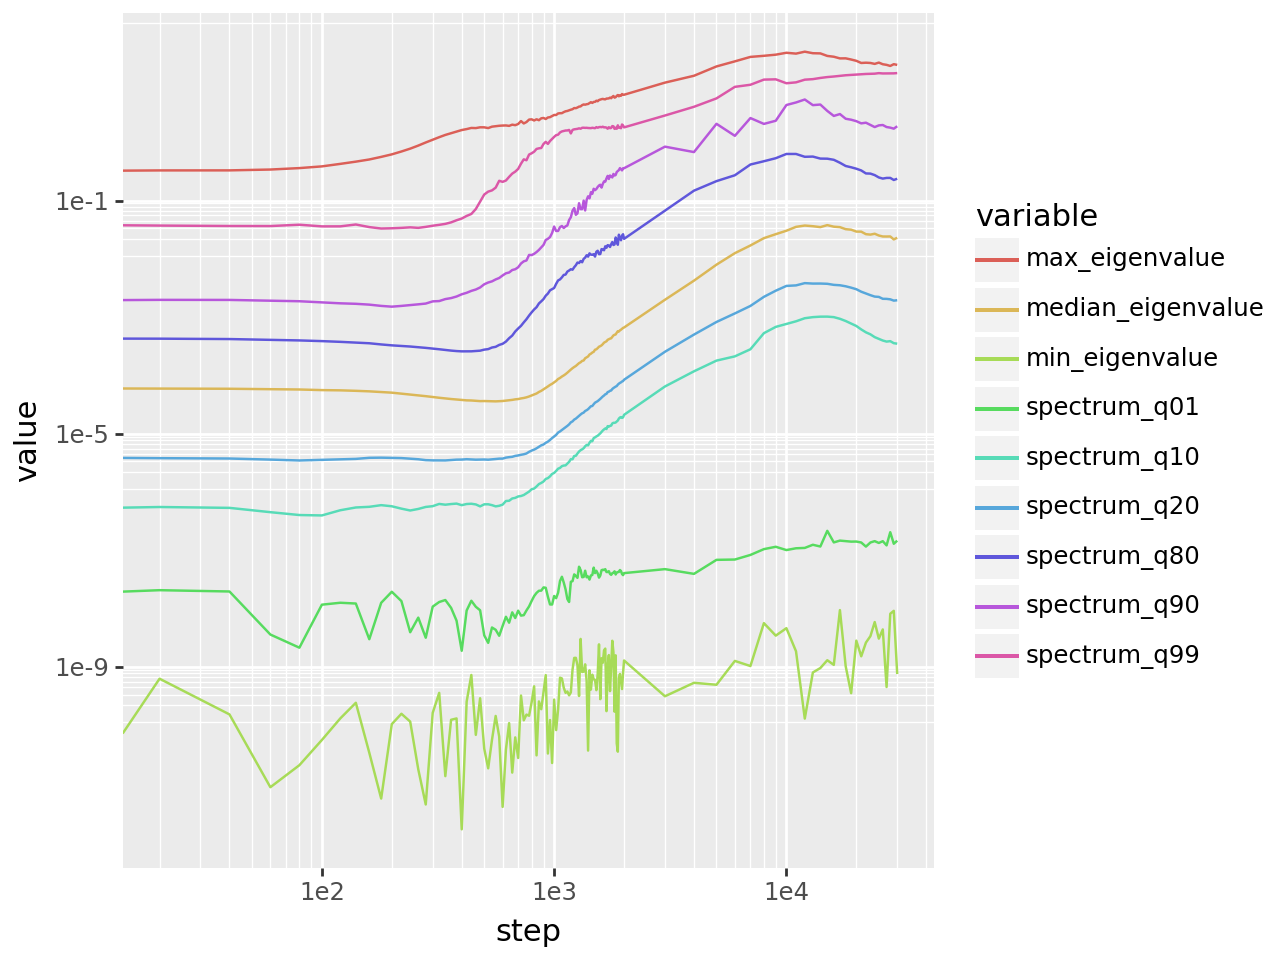

In [24]:
from plotnine import stat_ecdf, geom_line, scale_y_log10, scale_x_log10

df = (
    spectral_data
    .group_by('step')
    .agg(
        max_eigenvalue=pl.col('spectrum').abs().max(), 
        min_eigenvalue=pl.col('spectrum').abs().min(),
        median_eigenvalue=pl.col('spectrum').abs().quantile(0.5),
        spectrum_q01=pl.col('spectrum').abs().quantile(0.01),
        spectrum_q10=pl.col('spectrum').abs().quantile(0.1),
        spectrum_q20=pl.col('spectrum').abs().quantile(0.2),
        spectrum_q80=pl.col('spectrum').abs().quantile(0.8),
        spectrum_q90=pl.col('spectrum').abs().quantile(0.90),
        spectrum_q99=pl.col('spectrum').abs().quantile(0.99),
    )
    .unpivot(index='step')
)

ggplot(df, aes(x='step', y='value', color='variable')) + geom_line() + scale_y_log10() + scale_x_log10()

In [3]:
import optax
from jax.sharding import PartitionSpec as P, NamedSharding



def generate_boolean_cube(n: int):
    return np.sign(-1. * (generate_all_binary_arrays(n) - 0.5).astype(float))


@eqx.filter_jit(donate="all")
def compute_loss(model, batch_x, batch_y):
    pred = model(batch_x)
    
    targets_one_hot = jax.nn.one_hot(
        (batch_y == 1.).astype(int),
        num_classes=2
    )
    
    losses = optax.softmax_cross_entropy(
        pred,
        targets_one_hot
    )
    
    # Compute entropy of predictions
    return jnp.mean(losses)


n_devices = jax.device_count()
mesh = jax.make_mesh((n_devices,), ('tensor',))
sharded = jax.sharding.NamedSharding(mesh, P('tensor',))
replicated = jax.sharding.NamedSharding(mesh, P(None,))


cube = jnp.array(generate_boolean_cube(n))
#cube = jax.device_put(cube, sharded)
parities = cube.prod(axis=-1)
model = jax.device_put(model, replicated)


In [7]:
model(cube)

RuntimeError: Array has been deleted with shape=float32[128].

In [6]:
batch_grads = jax.grad(compute_loss)(
    model,
    jax.device_put(cube, sharded),
    jax.device_put(parities, sharded)
)

RuntimeError: Array has been deleted with shape=float32[128].

In [ ]:

import random

idx = random.randint(0, 128)
w = model.linear.weight[idx]
min_val = jnp.abs(w).min()
sorted_inds = jnp.argsort(jnp.abs(w))

w[sorted_inds] / min_val



def integer_proximity(numbers):
    # Calculate distance to nearest integer for each number
    distances = jnp.abs(jnp.round(numbers) - numbers)
    
    # Various metrics
    mean_distance = jnp.mean(distances, axis=1)
    rms_distance = jnp.sqrt(jnp.mean(jnp.square(distances), axis=1))
    max_distance = jnp.max(distances, axis=1)
    
    return {
        "mean_distance": mean_distance,
        "rms_distance": rms_distance,
        "max_distance": max_distance
    }


def max_min_ratio(tensor):
    max_val = jnp.abs(tensor).max(axis=1)
    min_val = jnp.abs(tensor).min(axis=1)
    return max_val / min_val



In [6]:


max_min_ratio(model.linear.weight)

Array([1.36076832e+01, 1.01089907e+00, 1.13628280e+00, 1.34055436e+00,
       2.62818604e+01, 1.00196207e+00, 3.00700688e+00, 2.28723907e+00,
       1.07678652e+00, 1.02928388e+00, 5.99805593e+00, 1.00488997e+00,
       1.02166009e+00, 7.25832367e+01, 1.20441580e+00, 1.01204538e+00,
       3.00331140e+00, 2.99916077e+00, 1.00456345e+00, 3.03349257e+00,
       5.11625195e+00, 1.01846135e+00, 1.20593655e+00, 1.00873601e+00,
       3.03239632e+00, 3.02076912e+00, 1.13607240e+00, 5.06811810e+00,
       1.02317607e+00, 5.01338577e+00, 1.00404048e+00, 3.02855945e+00,
       1.00950539e+00, 9.99937820e+00, 1.01065922e+00, 5.05198622e+00,
       1.01152742e+00, 3.02200413e+00, 1.02038729e+00, 9.05193996e+00,
       1.03855538e+00, 1.02810299e+00, 1.01784790e+00, 1.01207399e+00,
       5.23950386e+00, 1.08833275e+01, 1.00235491e+01, 5.01267242e+00,
       1.00871515e+00, 1.00399196e+00, 1.06735241e+00, 5.09424734e+00,
       1.12624383e+00, 1.71898508e+00, 1.01238036e+00, 1.02863967e+00,
      

In [7]:
data = []
steps = list(range(0, 2000, 20)) + list(range(1000, 30001, 1000))
for seed in range(17):
    config['seed'] = seed
    for step in steps:
        model = try_load_checkpoint(template, bucket_name, config, step)
        ckpt_data = np.array(max_min_ratio(model.linear.weight))
        df = pl.DataFrame({'max_min_ratio': ckpt_data})
        df = df.with_columns(step=pl.lit(step), seed=pl.lit(seed)).with_row_index()
        data.append(df)

weight_df = pl.concat(data, how='vertical').unpivot(index=['step', 'seed', 'index'])

KeyboardInterrupt: 

/home/dstander/deep-parity/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


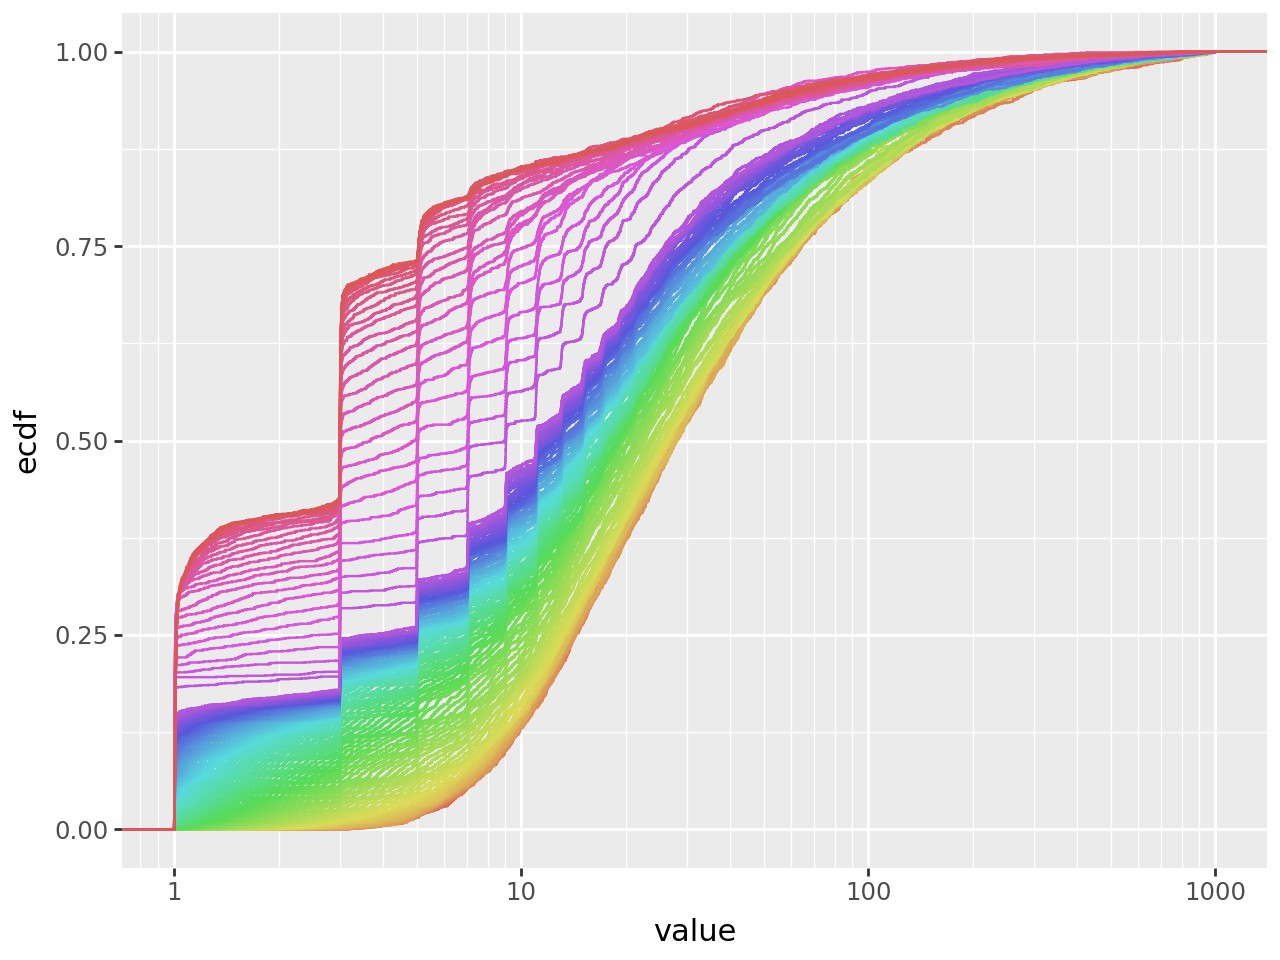

In [ ]:
from plotnine import ggplot, aes, theme, labs, geom_histogram, facet_wrap, stat_ecdf, scale_x_log10
df = weight_df.filter(pl.col('value').le(1000))

ggplot(df, aes(x='value', color='factor(step)')) + stat_ecdf(show_legend=False) + scale_x_log10()

In [ ]:
from jax.nn import relu


class Perceptron(eqx.Module):
    linear: eqx.Module
    unembed: eqx.Module

    def __init__(self, n: int, model_dim: int, key, use_bias=True):
        linear_key, unembed_key = jax.random.split(key)
        self.linear = eqx.nn.Linear(in_features=n, out_features=model_dim, use_bias=use_bias, key=linear_key)
        self.unembed = eqx.nn.Linear(in_features=model_dim, out_features=2, use_bias=False, key=unembed_key)
    
    def __call__(self, x):
        preactivations = self.linear(x)
        outputs = self.unembed(relu(preactivations))
        return outputs


n = 20
model_dim = 128
step = 30_000
seed = 0

config = {'model': {'n': n, 'model_dim': model_dim}, 'seed': seed}

bucket_name = "deep-parity-training-0"

key = jax.random.key(0)

template = Perceptron(n, model_dim, key)

model = try_load_checkpoint(template, bucket_name, config, step)


cube = generate_boolean_cube(n)
parities = cube.prod(axis=1)

In [ ]:
def compute_loss(model, batch_x, batch_y):
    pred = model(batch_x)
    
    targets_one_hot = jax.nn.one_hot(
        (batch_y == 1.).astype(int),
        num_classes=2
    )
    
    loss = optax.softmax_cross_entropy(
        pred,
        targets_one_hot
    )
    
    return loss

jax.vmap(jax.hessian(compute_loss), in_axes=(None, 0, 0))(model, cube[:8], parities[:8])

Perceptron(
  linear=Linear(
    weight=Perceptron(
      linear=Linear(
        weight=f32[8,128,20,128,20],
        bias=f32[8,128,20,128],
        in_features=20,
        out_features=128,
        use_bias=True
      ),
      unembed=Linear(
        weight=f32[8,128,20,2,128],
        bias=None,
        in_features=128,
        out_features=2,
        use_bias=False
      )
    ),
    bias=Perceptron(
      linear=Linear(
        weight=f32[8,128,128,20],
        bias=f32[8,128,128],
        in_features=20,
        out_features=128,
        use_bias=True
      ),
      unembed=Linear(
        weight=f32[8,128,2,128],
        bias=None,
        in_features=128,
        out_features=2,
        use_bias=False
      )
    ),
    in_features=20,
    out_features=128,
    use_bias=True
  ),
  unembed=Linear(
    weight=Perceptron(
      linear=Linear(
        weight=f32[8,2,128,128,20],
        bias=f32[8,2,128,128],
        in_features=20,
        out_features=128,
        use_bias=True


In [ ]:
import equinox as eqx
from functools import partial
import jax
import jax.numpy as jnp
from jax.nn import relu
from jax.sharding import PartitionSpec as P
from jax.experimental import mesh_utils



@jax.jit
def outerproduct(grad_triplet):
    """
    Compute the outer products of gradient matrices.
    
    Args:
        grad_triplet: A tuple of three matrices (mat1, mat2, mat3)
    
    Returns:
        List of outer products between all pairs of matrices
    """
    mat1, mat2, mat3 = grad_triplet
    return [
        jnp.outer(mat1, mat1.T),
        jnp.outer(mat1, mat2.T),
        jnp.outer(mat1, mat3.T),
        jnp.outer(mat2, mat2.T),
        jnp.outer(mat2, mat3.T),
        jnp.outer(mat3, mat3.T),
    ]


def partition_model_params(model, num_partitions):
    """
    Partition model parameters into roughly equal groups for parallel processing.
    
    Args:
        model: The model
        num_partitions: Number of partitions to create
    
    Returns:
        List of indices for each partition
    """
    # Get all parameters as flat list
    params = jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array))
    
    # Calculate indices to split the parameters
    total_params = len(params)
    partition_size = max(1, total_params // num_partitions)
    
    # Create the partition indices
    partitions = []
    for i in range(num_partitions):
        start_idx = i * partition_size
        end_idx = min(start_idx + partition_size, total_params)
        if start_idx < total_params:  # Ensure we don't create empty partitions
            partitions.append(list(range(start_idx, end_idx)))
    
    return partitions


def model_parallel_gauss_newton(model, all_data, all_targets, num_devices=8):
    """
    Compute Gauss-Newton matrix with model parallelism.
    Data is replicated across devices, while model parameter processing is split.
    
    Args:
        model: The model
        all_data: All input data
        all_targets: All target outputs
        num_devices: Number of devices to use
    
    Returns:
        Approximated Gauss-Newton matrix
    """
    # Set up device mesh
    actual_devices = min(num_devices, jax.device_count())
    devices = jax.devices()[:actual_devices]
    mesh = jax.sharding.Mesh(devices, ('model',))
    
    # Partition model parameters for parallel processing
    param_partitions = partition_model_params(model, actual_devices)
    
    # Compute all gradients first (replicated across devices)
    all_grads = jax.vmap(jax.grad(compute_loss), in_axes=(None, 0, 0))(model, all_data, all_targets)
    
    # Flatten gradients
    flat_grads = jax.tree_util.tree_leaves(all_grads)
    
    # Function to process a specific partition of gradients
    def process_partition(partition_idx):
        # Get indices for this partition  
        indices = param_partitions[partition_idx]
        
        # Extract gradients for this partition
        partition_grads = [flat_grads[i] for i in indices]
        
        # Compute outer products for each parameter in this partition
        outer_products = []
        for i, grad_i in enumerate(partition_grads):
            for j, grad_j in enumerate(flat_grads):  # Use all grads for second dimension
                # Compute outer product between grad_i and grad_j
                outer_product = jnp.mean(jnp.einsum('ba,bc->bac', 
                                                   grad_i.reshape(grad_i.shape[0], -1), 
                                                   grad_j.reshape(grad_j.shape[0], -1)), 
                                        axis=0)
                outer_products.append((indices[i], j, outer_product))
        
        return outer_products
    
    # Execute in parallel across devices
    with mesh:
        # Create device index array and shard it
        device_indices = jnp.arange(actual_devices)
        sharded_indices = jax.device_put(
            device_indices, 
            jax.sharding.NamedSharding(mesh, P('model'))
        )
        
        # Process partitions in parallel
        parallel_process = jax.pmap(process_partition, axis_name='model')
        partition_results = parallel_process(sharded_indices)
    
    # Collect and combine results from all devices
    all_results = []
    for result in partition_results:
        if result is not None:  # Filter out None results (from extra devices)
            all_results.extend(result)
    
    # Build the full Gauss-Newton matrix
    # We need to know the total parameter sizes to allocate the matrix
    param_shapes = [p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array))]
    total_params = sum(param_shapes)
    
    # Initialize Gauss-Newton matrix
    gn_matrix = jnp.zeros((total_params, total_params))
    
    # Fill in the matrix with computed blocks
    param_offsets = [0] + list(jnp.cumsum(jnp.array(param_shapes[:-1])))
    for i, j, block in all_results:
        i_start = param_offsets[i]
        i_end = i_start + param_shapes[i]
        
        j_start = param_offsets[j]
        j_end = j_start + param_shapes[j]
        
        # Handle different shapes properly
        if block.shape != (param_shapes[i], param_shapes[j]):
            block = block.reshape(param_shapes[i], param_shapes[j])
        
        gn_matrix = gn_matrix.at[i_start:i_end, j_start:j_end].set(block)
    
    return gn_matrix


def batched_model_parallel_gn(model, all_data, all_targets, num_devices=8, batch_size=None):
    """
    Compute Gauss-Newton matrix with model parallelism in batches to reduce memory usage.
    
    Args:
        model: The model
        all_data: All input data
        all_targets: All target outputs
        num_devices: Number of devices to use
        batch_size: Size of batches for processing (if None, use a heuristic)
    
    Returns:
        Approximated Gauss-Newton matrix
    """
    # Set up device mesh
    actual_devices = min(num_devices, jax.device_count())
    devices = jax.devices()[:actual_devices]
    mesh = jax.sharding.Mesh(devices, ('model',))
    
    # Get total data size
    data_size = all_data.shape[0]
    
    # Determine batch size if not provided
    if batch_size is None:
        # Heuristic: aim for ~8MB per batch per device
        param_size = sum(p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array)))
        batch_size = max(1, min(data_size, 8 * 1024 * 1024 // (param_size * 4 * actual_devices)))
    
    # Process in batches
    num_batches = (data_size + batch_size - 1) // batch_size
    
    # Initialize Gauss-Newton matrix
    param_shapes = [p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_array))]
    total_params = sum(param_shapes)
    gn_matrix = jnp.zeros((total_params, total_params))
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, data_size)
        
        # Get batch data
        batch_data = all_data[start_idx:end_idx]
        batch_targets = all_targets[start_idx:end_idx]
        
        # Compute Gauss-Newton for this batch
        batch_gn = model_parallel_gauss_newton(model, batch_data, batch_targets, num_devices)
        
        # Accumulate results
        gn_matrix += batch_gn * (end_idx - start_idx) / data_size
    
    return gn_matrix


# Example of partitioning Equinox model parameters for SPMD
def partition_equinox_model(model, num_partitions):
    """
    Create a more advanced partitioning scheme for Equinox models that respects parameter shapes.
    
    Args:
        model: Equinox model
        num_partitions: Number of partitions to create
    
    Returns:
        Dictionary mapping parameter paths to partition indices
    """
    # Get parameter leaves and their paths
    params, paths = eqx.partition(lambda l: True, model, is_leaf=lambda l: eqx.is_array(l))
    
    # Calculate total parameter count
    param_sizes = [p.size for p in jax.tree_util.tree_leaves(params)]
    total_size = sum(param_sizes)
    
    # Target size per partition
    target_size = total_size / num_partitions
    
    # Sort parameters by size (descending) to improve balance
    path_size_pairs = [(path, param_sizes[i]) for i, path in enumerate(paths)]
    path_size_pairs.sort(key=lambda x: x[1], reverse=True)
    
    # Greedy bin-packing
    partitions = [[] for _ in range(num_partitions)]
    partition_sizes = [0] * num_partitions
    
    for path, size in path_size_pairs:
        # Find the partition with the smallest current size
        min_idx = partition_sizes.index(min(partition_sizes))
        partitions[min_idx].append(path)
        partition_sizes[min_idx] += size
    
    # Create mapping from path to partition index
    path_to_partition = {}
    for i, partition in enumerate(partitions):
        for path in partition:
            path_to_partition[path] = i
    
    return path_to_partition


# Code to assist with verifying sharding and device usage
def debug_jax_devices():
    """Print information about JAX devices for debugging."""
    print(f"JAX version: {jax.__version__}")
    print(f"Available devices: {jax.devices()}")
    print(f"Device count: {jax.device_count()}")
    print(f"Process count: {jax.process_count()}")
    print(f"Process index: {jax.process_index()}")
    
    # Also print memory info if available
    try:
        import jax.profiler as profiler
        memory_stats = profiler.device_memory_profile()
        print("\nDevice memory stats:")
        for device, stats in memory_stats.items():
            print(f"  {device}: {stats['bytes_in_use'] / 1024**2:.2f}MB used out of {stats['bytes_limit'] / 1024**2:.2f}MB")
    except (ImportError, AttributeError):
        print("\nJAX profiler not available for memory stats")


# Example usage:
num_devices = 8  # Number of TPU devices
gn_matrix = model_parallel_gauss_newton(model, cube[:128], parities[:128], num_devices)

TracerIntegerConversionError: The __index__() method was called on traced array with shape int32[]
The error occurred while tracing the function process_partition at /tmp/ipykernel_572203/3631699371.py:91 for pmap. This concrete value was not available in Python because it depends on the value of the argument partition_idx.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerIntegerConversionError

In [ ]:
from jax.sharding import PartitionSpec as P

mesh = jax.make_mesh((8,), ('tensor',))
sharding = jax.sharding.NamedSharding(mesh, P('tensor'))
print(sharding)

NamedSharding(mesh=Mesh('tensor': 8, axis_types=(Auto,)), spec=PartitionSpec('tensor',), memory_kind=device)


In [ ]:
w = model.linear.weight[1063]
w /= jnp.abs(w).min()
w


Array([-12.532241 ,   1.1883148,  10.201176 ,   1.1944492,  -7.897953 ,
       -12.536243 ,  -5.7297616,  -3.3222394,   1.2189453,   5.6909466,
         5.7965074,  -1.2161019, -12.5576   ,  -1.2657564, -12.54254  ,
         3.443496 ,  -5.5762854,  10.143881 ,   1.       ,  -1.0177622],      dtype=float32)

In [ ]:
model.linear.weight[idx] / 0.083

Array([-2.8296783, -1.0034753, -1.0094928, -2.8179123,  2.8179123,
       -2.8088288,  2.8179126, -1.0100446, -2.8179128,  2.8179126,
       -2.8179123,  2.8179123,  2.8137658, -1.0151417,  1.0101205,
        2.8263743, -2.8110478, -2.8179123, -2.826138 ,  2.814731 ],      dtype=float32)

In [ ]:
jnp.unique_counts(jnp.abs(jnp.round(model.linear.weight[idx], 2)), size=20, fill_value=-1)

_UniqueCountsResult(values=Array([ 0.08      ,  0.22999999, -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ],      dtype=float32), counts=Array([ 5, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32))